In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from keras.utils import to_categorical

import tensorflow as tf #Framework para deep learning
from tensorflow import keras
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch #API que contiene la mayoría de funciones para las RN

from keras import layers
##### REGULARIZACION #####
from keras import regularizers

import random

from importlib import reload
import utils  # Importa el módulo
reload(utils)  # Recarga el módulo

<module 'utils' from 'c:\\Users\\Usuario\\OneDrive - Universidad de Antioquia\\Documentos\\Universidad\\Analitica2\\deep_learning\\utils.py'>

In [37]:
x_train, y_train, x_test, y_test = utils.get_data(112)

----------Train----------
paper
rock
scissors
----------Test----------
paper
rock
scissors


In [382]:
# Establecer la semilla para NumPy
np.random.seed(17)

# Establecer la semilla para Python
random.seed(17)

# Establecer la semilla para TensorFlow v1.x
tf.compat.v1.set_random_seed(17)

In [383]:
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

In [384]:
### Estandarización de los datos
x_train2 = x_train/255
x_test2 = x_test/255
x_train2.shape

(2520, 112, 112)

# Red Neuronal

## Primera red neuronal

In [417]:
model = keras.Sequential()

# Bloque convolucional 1
model.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu',
        input_shape = (112, 112, 1)
    )
)
model.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Bloque convolucional 2
model.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu'
    )
)
model.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Aplanar y agregar capas densas
model.add(
    layers.Flatten()
)

model.add(
    layers.Dense(128,
    activation ='relu'
    )
)

model.add(
    layers.Dense(
        3,
        activation='softmax'
        )
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 55, 55, 16)        272       
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 26, 26, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_101 (Conv2D)         (None, 12, 12, 16)        4112      
                                                                 
 max_pooling2d_100 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                                                 
 flatten_25 (Flatten)        (None, 400)               0         
                                                                 
 dense_94 (Dense)            (None, 128)             

### Ajuste de datos al modelo

In [418]:
history = model.fit(
    x_train2,
    y_train2,
    epochs= 20,
    validation_split=0.2)

Epoch 1/20
63/63 [==============================] - 3s 21ms/step - loss: 0.7542 - accuracy: 0.6850 - val_loss: 1.2962 - val_accuracy: 0.3631
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 0.1783 - accuracy: 0.9499 - val_loss: 1.5788 - val_accuracy: 0.4345
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0438 - accuracy: 0.9950 - val_loss: 2.5920 - val_accuracy: 0.4167
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.0187 - accuracy: 0.9995 - val_loss: 2.3059 - val_accuracy: 0.5317
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 3.0491 - val_accuracy: 0.4623
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 3.1061 - val_accuracy: 0.5040
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.0435 - val_accuracy: 0.5238
Epoch 8/20
63

### Evaluación

In [419]:
class_names = ['papel','piedra','tijera']

y_hat = np.argmax(model.predict(x_test2), axis = 1)

12/12 [==============================] - 0s 6ms/step


In [420]:
print(classification_report(y_test, y_hat, target_names=class_names))

              precision    recall  f1-score   support

       papel       0.72      0.90      0.80       124
      piedra       0.91      0.94      0.93       124
      tijera       0.87      0.62      0.72       124

    accuracy                           0.82       372
   macro avg       0.83      0.82      0.82       372
weighted avg       0.83      0.82      0.82       372



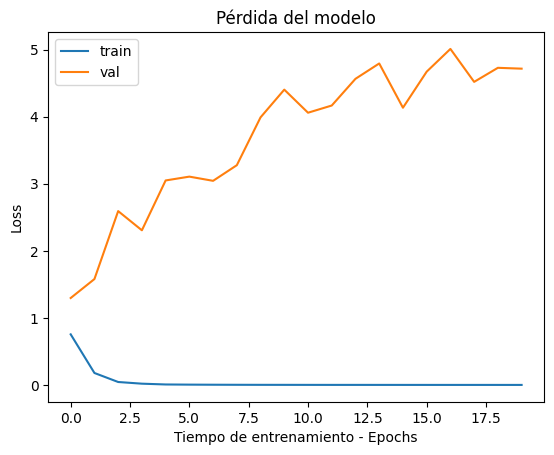

In [423]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

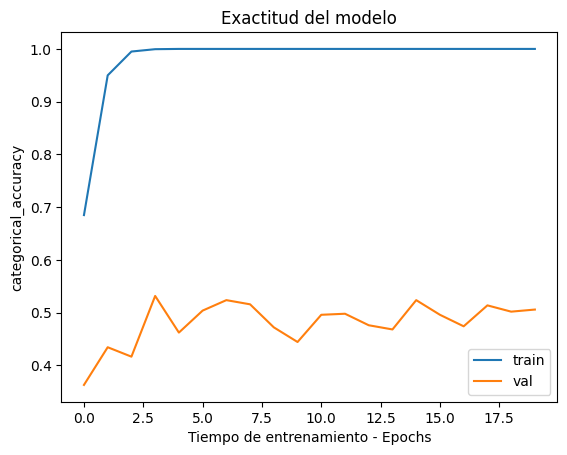

In [424]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('categorical_accuracy')
plt.legend(['train', 'val'])
plt.show()

El modelo tiene un buen comportamiento en el entrenamiento pero se presenta un grave caso de sobreajuste ya que las métricas de validación son muy bajas.

A continuación se ajustará una red neuronal que extraiga mas características, es decir con mas bloques convolucionales con un mayor numero de filtros y tamaños de kernel y de agrupación mas pequeños, para observar si esto permite subir las metricas en validacion y reducir el sobreajuste.

## Segunda red neuronal

In [570]:
model2 = keras.Sequential()

# Bloque convolucional 1
model2.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu',
        input_shape = (112, 112, 1)
    )
)
model2.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Bloque convolucional 2
model2.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu'
    )
)
model2.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Bloque convolucional 3
model2.add(
    layers.Conv2D(
        filters = 32,
        kernel_size = (2, 2),
        strides = (1,1),
        activation='relu'
    )
)
model2.add(
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (1,1)    
    )
)

# Bloque convolucional 4
model2.add(
    layers.Conv2D(
        filters = 32,
        kernel_size = (2, 2),
        strides = (1,1),
        activation='relu'
    )
)
model2.add(
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (1,1)    
    )
)

# Aplanar y agregar capas densas
model2.add(
    layers.Flatten()
)

model2.add(
    layers.Dense(128,
    activation ='relu'
    )
)

model2.add(
    layers.Dense(64,
    activation ='relu'
    )
)


model2.add(
    layers.Dense(32,
    activation ='relu'
    )
)


model2.add(
    layers.Dense(
        3,
        activation='softmax'
        )
)

# Compilar el modelo
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 55, 55, 16)        272       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 26, 26, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 12, 12, 16)        4112      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 3, 3, 32)        

## Ajustar datos al modelo

In [571]:
history2 = model2.fit(
    x_train2,
    y_train2,
    epochs= 50,
    validation_split=0.2
)

Epoch 1/50
63/63 [==============================] - 2s 12ms/step - loss: 1.0176 - accuracy: 0.4658 - val_loss: 2.3047 - val_accuracy: 0.0000e+00
Epoch 2/50
63/63 [==============================] - 1s 9ms/step - loss: 0.7003 - accuracy: 0.6890 - val_loss: 1.2749 - val_accuracy: 0.0000e+00
Epoch 3/50
63/63 [==============================] - 1s 9ms/step - loss: 0.2739 - accuracy: 0.8730 - val_loss: 2.7527 - val_accuracy: 0.2202
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 0.1600 - accuracy: 0.9400 - val_loss: 0.4153 - val_accuracy: 0.8016
Epoch 5/50
63/63 [==============================] - 1s 9ms/step - loss: 0.0637 - accuracy: 0.9812 - val_loss: 1.4556 - val_accuracy: 0.5952
Epoch 6/50
63/63 [==============================] - 1s 9ms/step - loss: 0.0241 - accuracy: 0.9970 - val_loss: 1.0589 - val_accuracy: 0.6409
Epoch 7/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 1.1365 - val_accuracy: 0.6687
Epoch 8/5

## Evaluación

In [572]:
class_names = ['papel','piedra','tijera']

y_hat2 = np.argmax(model2.predict(x_test2), axis = 1)



12/12 [==============================] - 0s 3ms/step


In [573]:
print(classification_report(y_test, y_hat2, target_names=class_names))

              precision    recall  f1-score   support

       papel       0.93      0.90      0.91       124
      piedra       0.94      1.00      0.97       124
      tijera       0.92      0.88      0.90       124

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372



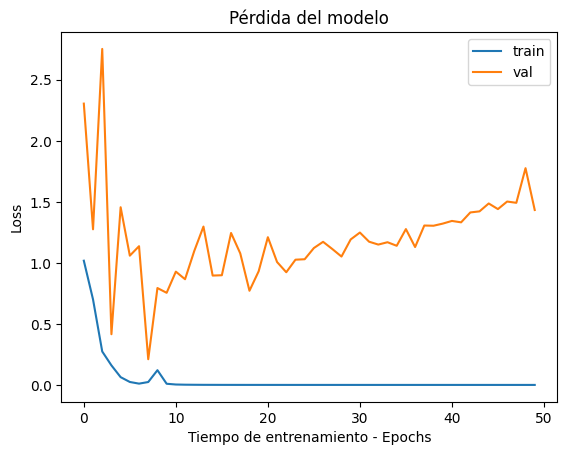

In [574]:
### Visualización de las curvas de error
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

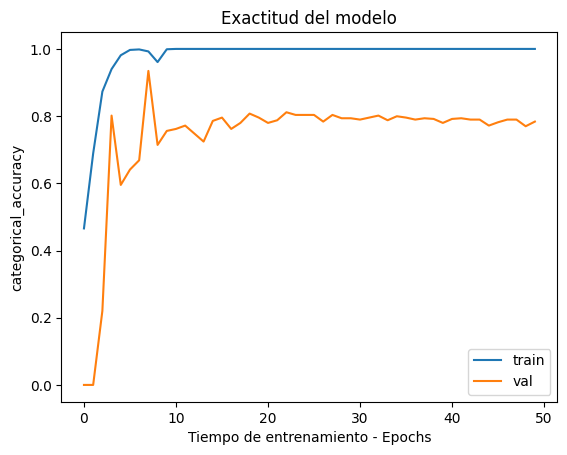

In [575]:
### Visualización de las curvas de error
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('categorical_accuracy')
plt.legend(['train', 'val'])
plt.show()

Confirmando la hipótesis, al tener un modelo con mayor detalle si aumentaron las métricas de validación y hubo una importante reducción del sobreajuste, logrando con esto un modelo muy satisfactorio. Se continuará con la regularización del modelo para tratar de reducir un poco mas el sobreajuste. Se aplicara una regularización l2 con un valor de 0.01 a cada una de las capas densas y un dropout de 0.1 despues de la primer capa densa.

## Aplicar regularización

In [506]:
model_l2 = keras.Sequential()

# Bloque convolucional 1
model_l2.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu',
        input_shape = (112, 112, 1)
    )
)
model_l2.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Bloque convolucional 2
model_l2.add(
    layers.Conv2D(
        filters = 16,
        kernel_size = (4, 4),
        strides = (2,2),
        activation='relu'
    )
)
model_l2.add(
    layers.MaxPooling2D(
        pool_size = (4, 4),
        strides = (2,2)    
    )
)

# Bloque convolucional 3
model_l2.add(
    layers.Conv2D(
        filters = 32,
        kernel_size = (2, 2),
        strides = (1,1),
        activation='relu'
    )
)
model_l2.add(
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (1,1)
    )
)

# Bloque convolucional 4
model_l2.add(
    layers.Conv2D(
        filters = 32,
        kernel_size = (2, 2),
        strides = (1,1),
        activation='relu'
    )
)
model_l2.add(
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (1,1)    
    )
)

# Aplanar y agregar capas densas
model_l2.add(
    layers.Flatten()
)

model_l2.add(
    layers.Dense(128,
    activation ='relu',
    kernel_regularizer = regularizers.l2(l2 = 0.01)
    )
)
model_l2.add(
    layers.Dropout(0.1)
)

model_l2.add(
    layers.Dense(64,
    activation ='relu',
    kernel_regularizer = regularizers.l2(l2 = 0.01)
    )
)


model_l2.add(
    layers.Dense(32,
    activation ='relu',
    kernel_regularizer = regularizers.l2(l2 = 0.01)
    )
)


model_l2.add(
    layers.Dense(
        3,
        activation='softmax'
        )
)  # 10 clases para los 10 tipos de animales

# Compilar el modelo
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model_l2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 55, 55, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        4112      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 32)         

## Ajustar datos al modelo regularizado

In [507]:
history3 = model_l2.fit(
    x_train2,
    y_train2,
    epochs= 50,
    validation_split=0.2
)

Epoch 1/50
63/63 [==============================] - 2s 15ms/step - loss: 2.1977 - accuracy: 0.4167 - val_loss: 2.5891 - val_accuracy: 0.0000e+00
Epoch 2/50
63/63 [==============================] - 1s 9ms/step - loss: 1.3947 - accuracy: 0.5228 - val_loss: 2.4844 - val_accuracy: 0.0000e+00
Epoch 3/50
63/63 [==============================] - 1s 9ms/step - loss: 0.6981 - accuracy: 0.7991 - val_loss: 1.9869 - val_accuracy: 0.0000e+00
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 0.4128 - accuracy: 0.9062 - val_loss: 0.9750 - val_accuracy: 0.6091
Epoch 5/50
63/63 [==============================] - 1s 10ms/step - loss: 0.2446 - accuracy: 0.9767 - val_loss: 3.4562 - val_accuracy: 0.0774
Epoch 6/50
63/63 [==============================] - 1s 10ms/step - loss: 0.2045 - accuracy: 0.9787 - val_loss: 0.6519 - val_accuracy: 0.7877
Epoch 7/50
63/63 [==============================] - 1s 10ms/step - loss: 0.1381 - accuracy: 0.9990 - val_loss: 0.2785 - val_accuracy: 0.9325
Epo

Evaluación

In [513]:
class_names = ['papel','piedra','tijera']

y_hat3 = np.argmax(model_l2.predict(x_test2), axis = 1)

12/12 [==============================] - 0s 3ms/step


In [515]:
print(classification_report(y_test, y_hat3, target_names=class_names))

              precision    recall  f1-score   support

       papel       0.93      0.97      0.95       124
      piedra       1.00      0.99      1.00       124
      tijera       0.96      0.93      0.94       124

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372



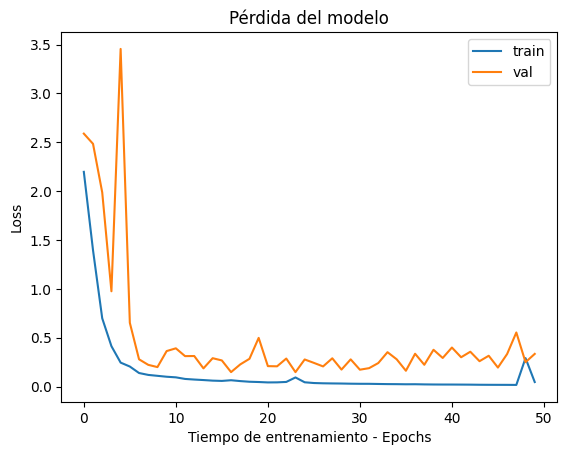

In [511]:
### Visualización de las curvas de error
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

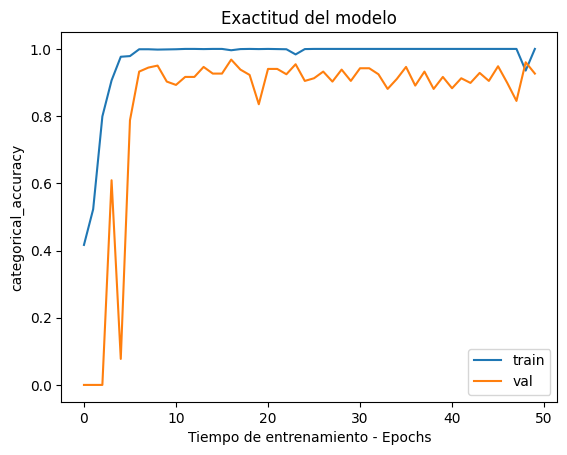

In [512]:
### Visualización de las curvas de error
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('categorical_accuracy')
plt.legend(['train', 'val'])
plt.show()

Al hacer la regularización parece ser que el modelo logro bajar un poco el sobreajuste y las metricas de evaluación en test son mejores, se procedere a hacer un tuning de hiperparametros para tratar de encontrar un modelo mejor

### Afinamiento de hiperparámetros

Se decide hacer la busqueda de hiperparametros para el numero de neuronas de las 3 capas densas asi como de los valores de dropout y del factor de regularizacion l2 para tratar de reducir el sobreajuste, estos valores iniciaran en 0 para tomar en cuenta si el modelo es mejor sin la regularización o con ella.

In [472]:
### Afinamiento de Hiperparámetros
hp = kt.HyperParameters()
lo = keras.losses.CategoricalCrossentropy()
name_metric = "prueba"
m2 = keras.metrics.CategoricalAccuracy(name= name_metric)

def tun_model(hp):
    dor = hp.Float('DOR', min_value = 0, max_value= 0.6, step=0.1)
    l2 = hp.Float('REG', min_value = 0, max_value= 0.1, step=0.01)
    units_1 = hp.Int('UNITS_1', min_value = 256, max_value=512, step=32)
    units_2 = hp.Int('UNITS_2', min_value = 64, max_value=256, step=32)
    units_3 = hp.Int('UNITS_3', min_value = 4, max_value=64, step=4) 
    
    model = keras.Sequential()

    # Bloque convolucional 1
    model.add(
        layers.Conv2D(
            filters = 16,
            kernel_size = (4, 4),
            strides = (2,2),
            activation='relu',
            input_shape = (112, 112, 1)
        )
    )
    model.add(
        layers.MaxPooling2D(
            pool_size = (4, 4),
            strides = (2,2)    
        )
    )

    # Bloque convolucional 2
    model.add(
        layers.Conv2D(
            filters = 16,
            kernel_size = (4, 4),
            strides = (2,2),
            activation='relu'
        )
    )
    model.add(
        layers.MaxPooling2D(
            pool_size = (4, 4),
            strides = (2,2)    
        )
    )

    # Bloque convolucional 3
    model.add(
        layers.Conv2D(
            filters = 32,
            kernel_size = (2, 2),
            strides = (1,1),
            activation='relu'
        )
    )
    model.add(
        layers.MaxPooling2D(
            pool_size = (2, 2),
            strides = (1,1)    
        )
    )

    # Bloque convolucional 4
    model.add(
        layers.Conv2D(
            filters = 32,
            kernel_size = (2, 2),
            strides = (1,1),
            activation='relu'
        )
    )
    model.add(
        layers.MaxPooling2D(
            pool_size = (2, 2),
            strides = (1,1)    
        )
    )

    # Aplanar y agregar capas densas
    model.add(
        layers.Flatten()
    )

    model.add(
        layers.Dense(
        units = units_1,
        activation ='relu',
        kernel_regularizer = regularizers.l2(l2 = l2)
        )
    )

    model.add(
        layers.Dropout(dor)
    )

    model.add(
        layers.Dense(
        units = units_2,
        activation ='relu',
        kernel_regularizer = regularizers.l2(l2 = l2)
        )
    )

    model.add(
        layers.Dense(
        units = units_3,
        activation ='relu',
        kernel_regularizer = regularizers.l2(l2 = l2)
        )
    )


    model.add(
        layers.Dense(
            3,
            activation='softmax'
            )
    )
    
   
    opt = keras.optimizers.Adam (learning_rate=0.01)
    model.compile(optimizer= opt, loss=lo, metrics=m2)
    
    return model

## Ajustar busqueda aleatoria

In [473]:
search_model = kt.RandomSearch(
    hypermodel = tun_model,
    hyperparameters = hp,
    objective = kt.Objective(name_metric, direction = 'max'),
    max_trials = 30,
    directory = 'results_tuner',
    project_name = 'PSR'
)

In [474]:
search_model.search(x_train2, y_train2, epochs=20, validation_split = 0.2)
search_model.results_summary()

Trial 30 Complete [00h 00m 19s]
prueba: 0.9826388955116272

Best prueba So Far: 0.9920634627342224
Total elapsed time: 00h 13m 39s
Results summary
Results in results_tuner\PSR
Showing 10 best trials
Objective(name="prueba", direction="max")

Trial 21 summary
Hyperparameters:
DOR: 0.1
REG: 0.01
UNITS_1: 288
UNITS_2: 256
UNITS_3: 24
Score: 0.9920634627342224

Trial 23 summary
Hyperparameters:
DOR: 0.4
REG: 0.06
UNITS_1: 256
UNITS_2: 64
UNITS_3: 36
Score: 0.983134925365448

Trial 29 summary
Hyperparameters:
DOR: 0.2
REG: 0.02
UNITS_1: 256
UNITS_2: 224
UNITS_3: 16
Score: 0.9826388955116272

Trial 22 summary
Hyperparameters:
DOR: 0.0
REG: 0.08
UNITS_1: 448
UNITS_2: 64
UNITS_3: 56
Score: 0.4634920656681061

Trial 24 summary
Hyperparameters:
DOR: 0.2
REG: 0.06
UNITS_1: 320
UNITS_2: 128
UNITS_3: 52
Score: 0.4583333432674408

Trial 03 summary
Hyperparameters:
DOR: 0.1
REG: 0.08
UNITS_1: 448
UNITS_2: 64
UNITS_3: 44
Score: 0.42658731341362

Trial 08 summary
Hyperparameters:
DOR: 0.5
REG: 0.08
UNI

## Elegir mejor modelo encontrado

In [488]:
### Mostrar el mejor modelo
for h_param in [f"UNITS_{i}" for i in range(1,4)]:
                print(h_param, search_model.get_best_hyperparameters()[0].get(h_param))

### Almacenar el mejor modelo
best_model = search_model.get_best_models()[0]
### Definir la arquitectura del modelo según hiperparámetros optimos
best_model.build(x_train2.shape)
### Resumen de la arquitectura
best_model.summary()

UNITS_1 288
UNITS_2 256
UNITS_3 24
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        4112      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_2 (Max

El mejor modelo encontrado atraves de la busqueda de aleatoria de hiperparametros nos dio como resultado un modelo con los siguientes HP

* DOR: 0.1
* REG: 0.01
* UNITS_1: 288
* UNITS_2: 256
* UNITS_3: 24
* Score: 0.9920634627342224

Se continua haciendo el ajuste de los datos al modelo, haciendo su evaluacion y comparandolo con el modelo 2 que es el mejor hasta ahora

## Ajustar datos al modelo 

In [476]:
### Ajuste de la red neuronal con hiperparámetros optimos
history4 = best_model.fit(x_train2, y_train2, epochs=50, validation_split=0.2 )

### Cual es el epoch con max val_accuracy
val_accuracy_per_epoch = history4.history['val_prueba']
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch))+1
print(f"Best epoch: {best_epoch}")


Epoch 1/50
63/63 [==============================] - 2s 13ms/step - loss: 0.0468 - prueba: 0.9294 - val_loss: 2.4538 - val_prueba: 0.5655
Epoch 2/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0703 - prueba: 0.9851 - val_loss: 0.8048 - val_prueba: 0.7917
Epoch 3/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0691 - prueba: 0.9901 - val_loss: 1.8399 - val_prueba: 0.6508
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0420 - prueba: 0.9965 - val_loss: 2.4091 - val_prueba: 0.5437
Epoch 5/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0347 - prueba: 0.9980 - val_loss: 1.9237 - val_prueba: 0.5615
Epoch 6/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0363 - prueba: 0.9970 - val_loss: 2.2953 - val_prueba: 0.5159
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0376 - prueba: 0.9955 - val_loss: 1.1125 - val_prueba: 0.7321
Epoch 8/50
63/63 [=======================

## Evaluación y Comparación de modelos

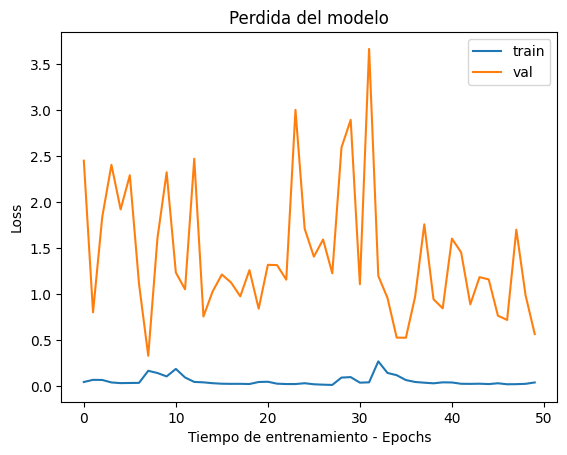

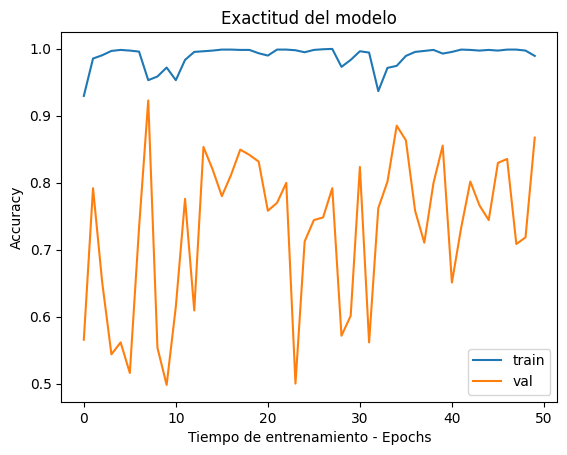

In [479]:
### Visualización de las curvas de error
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

### Visualización de las curvas de error
plt.plot(history4.history['prueba'])
plt.plot(history4.history['val_prueba'])
plt.title('Exactitud del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

In [480]:
### Utilizar el metodo evaluate para evaluar la red neuronal
test_loss, test_accuracy = best_model.evaluate(x_test2, y_test2)
print('Test accuracy: ', test_accuracy)

12/12 [==============================] - 0s 4ms/step - loss: 0.5057 - prueba: 0.8844
Test accuracy:  0.8844085931777954


In [578]:
test_loss, test_accuracy = model_l2.evaluate(x_test2, y_test2)
print('Test accuracy: ', test_accuracy)

12/12 [==============================] - 0s 4ms/step - loss: 0.1578 - accuracy: 0.9624
Test accuracy:  0.9623655676841736


Revisando las graficas de la exactitud del modelo se puede notar que el modelo obtenido con el tuner de HP es muy erratico y su sobreajuste es mayor que el modelo 2. Lo que se verifica cuando se evaluan ambos modelos con los datos de test, el modelo 3 con regularización es el seleccionado como el mejor con una exactitud del 96% en test

In [ ]:
class_names = ['papel','piedra','tijera']

y_hat3 = np.argmax(model.predict(x_test2), axis = 1)

# Visualización de errores

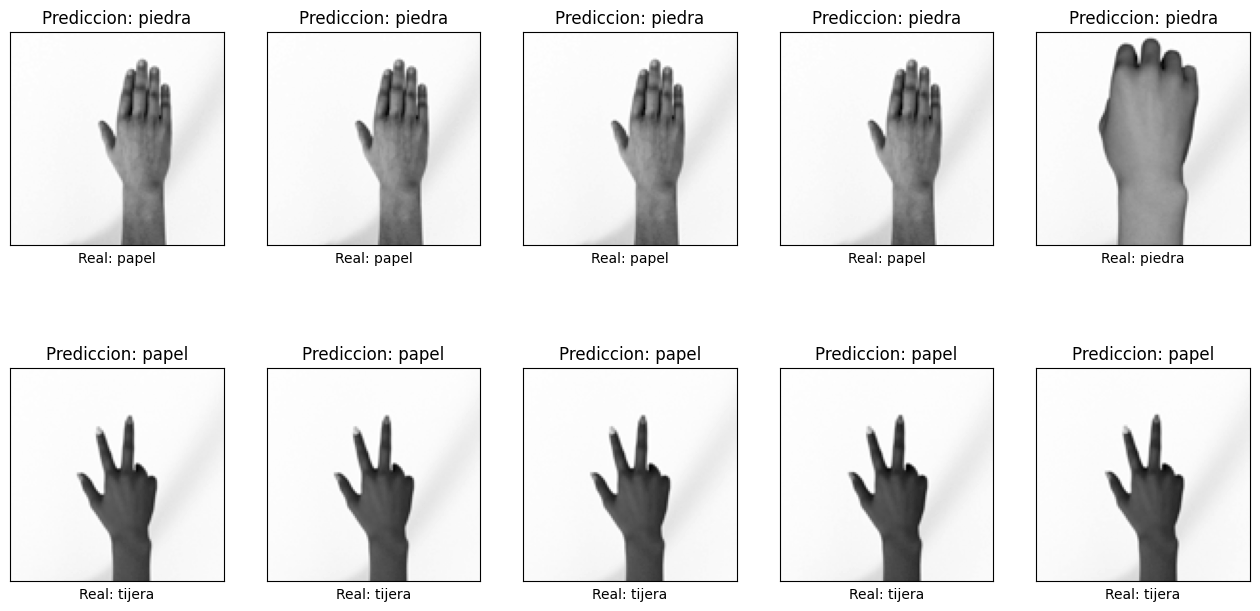

In [518]:
errors = np.nonzero(y_hat3 != y_test)[0]

# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 8))
for i, incorrect in enumerate(errors[0:10]):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[incorrect].reshape(112,112), cmap = 'gray')
    plt.title("Prediccion: {}".format(class_names[y_hat[incorrect]]))
    plt.xlabel("Real: {}".format(class_names[y_test[incorrect]]))

# Modelo de Shallow Learning - Random Forest Classifier

Los Random Forests tienen la capacidad de manejar el sobreajuste (overfitting) mejor que otros modelos más complejos en conjuntos de datos pequeños o cuando hay ruido en los datos.

En algunas ocasiones, puede encontrarse que un Random Forest ofrece un rendimiento satisfactorio en comparación con modelos más complejos, especialmente si el conjunto de datos no es muy grande o si la complejidad del problema no exige modelos más sofisticados.

## Ajuste de los datos

In [584]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]
x_trainrf, x_testrf = x_train2.reshape(n_train, -1), x_test2.reshape(n_test, -1)


## Modelo

In [610]:
ranfor = RandomForestClassifier(n_estimators=300,
                                  max_depth=30,
                                  n_jobs=-1,
                                  max_leaf_nodes=20,
                                  min_samples_leaf=10,
                                  random_state=42,
                                  class_weight='balanced').fit(x_trainrf,y_train)
y_pred_train = ranfor.predict(x_trainrf)

In [611]:
class_names = ['papel','piedra','tijera']

## Evaluación

In [612]:
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

       papel       1.00      0.98      0.99       840
      piedra       0.98      1.00      0.99       840
      tijera       1.00      1.00      1.00       840

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520



In [613]:
y_pred_test = ranfor.predict(x_testrf)
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

       papel       0.54      0.68      0.60       124
      piedra       0.67      0.60      0.64       124
      tijera       0.62      0.52      0.56       124

    accuracy                           0.60       372
   macro avg       0.61      0.60      0.60       372
weighted avg       0.61      0.60      0.60       372



A pesar de obtener buenas métricas en entrenamiento, por la poca variabilidad de las imagenes disponibles el modelo con random forest se esta aprendiendo muy bien los datos pero cuando se enfrenta a nuevas imagenes no las sabe interpretar, problema que tambien estaba prensente en la CNN pero se pudo solucionar.

# Conclusión

* Las imágenes que tenemos disponibles son muy parecidas entre sí, incluso parecen replicas con más o menos zoom, por tanto el modelo aprende los datos que tiene de memoria y al estos ser tan reducidos causa que el modelo se comporte muy bien en el entrenamiento sin tener en cuenta la complejidad del modelo pero le cuesta mucho cuando ve datos nuevos por eso el gran sobreajuste, si se quiere mejorar esto deberían obtenerse nuevas imágenes más variadas.



